## Здравствуйте, меня зовут *Дарья Петренко*, вот моё Задание №2 по курсу ПСАД-2020!

In [65]:
import pandas as pd
import numpy as np
import scipy as sp
from collections import defaultdict
from matplotlib import pyplot as plt

import seaborn as sns
sns.set()

np.random.seed(228)

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

In [66]:
from scipy.stats import t, norm, binom, beta

### Задача 1  

Задана выборка, включающая значения переменной $X$. 

X sample mean:  5.206


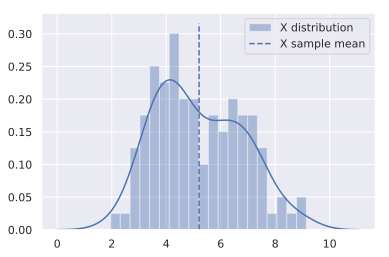

In [67]:
X = pd.read_excel('t1_data.xlsx').values.ravel()

sns.distplot(X, label='X distribution', bins=20)
plt.vlines(X.mean(), *plt.ylim(), linestyles='--', colors='b', label="X sample mean")
plt.legend()
print("X sample mean: ", np.round(X.mean(), 3))
plt.show()

Определите доверительный интервал для математического ожидания на уровне $\alpha$ (для каждого $\alpha$ из списка) c использованием...

In [68]:
alpha_list = np.array([0.1, 0.075, 0.05, 0.025, 0.01]) 

Распределения Стьюдента

In [69]:
def student_mci(data, alpha=0.05):
    N = data.shape[0]
    S = np.std(data, ddof=1)
    X_mean = X.mean()
    quant = t.ppf(1 - alpha / 2, N - 1)
    low = X_mean - quant * S / np.sqrt(N)
    up = X_mean + quant * S / np.sqrt(N)
    
    return low, up

Бутстрэп оценивания

In [70]:
def bootstrap_mci(data, alpha=0.05):
    B = 10000
    N = data.shape[0]
    bst_array = np.random.choice(data, (B, N))
    bst_mean = np.mean(bst_array, axis=1)
    mu = np.mean(bst_mean)
    
    bst_err = np.sqrt(1 / (B - 1) * np.sum((bst_mean - mu) ** 2))
    quant = t.ppf(1 - alpha / 2, N - 1)
    low = mu - quant * bst_err
    up = mu + quant * bst_err
    
    return low, up

Сравните результаты и сделайте выводы.

In [71]:
res = defaultdict(list)
res["alpha"] = alpha_list
res["Student"] = [np.round(student_mci(X, alpha), 3) for alpha in alpha_list]
res["Bootstrap"] = [np.round(bootstrap_mci(X, alpha), 3) for alpha in alpha_list]
res = pd.DataFrame(res)
res

,alpha,Student,Bootstrap
0,0.100,"[4.956, 5.456]","[4.956, 5.452]"
1,0.075,"[4.935, 5.477]","[4.935, 5.478]"
2,0.050,"[4.907, 5.505]","[4.911, 5.501]"
3,0.025,"[4.863, 5.549]","[4.863, 5.549]"
4,0.010,"[4.81, 5.602]","[4.81, 5.601]"


**Выводы:**
В большинстве случаев (единственное исключение - alpha=0.75, но и в этом случае различие незначительное) длина доверительного интервала бутстрэп оценивания не больше, чем для оценивания с использованием распределения Стьюдента. Более того, в нескольких случаях его длина намного меньше, и он вложен в доверительный интервал распределения Стьюдента.

Оценивание доверительного интервала при помощи распределения Стьюдента производится с использованием центральной предельной теоремы (предполагается, что эмпирическое среднее выборки распределено нормально). В нашем случае размер выборки достаточно большой, что позволяет достаточно точно оценить границы доверительного интервала таким способом. Поэтому разница между результатами двух методов незначительна.

### Задача 2

Два предприятия выпускают  изделия одного и того же назначения. Предприятие I выпускает изделия с математическим ожиданием срока службы $T_1$, предприятие II выпускает изделия с математическим ожиданием срока службы $T_2$. Сроки службы изделий обоих предприятий распределены нормально и стандартные отклонения для них равны $\sigma_1$ и $\sigma_2$ соответственно. При этом $T_1 < T_2$, но изделия второго предприятия дороже.

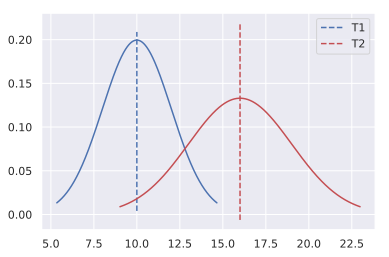

In [72]:
T1, T2, sigma1, sigma2 = 10, 16, 2, 3

def plot_T(T, sigma, c, label):
    norm = sp.stats.norm(loc=T, scale=sigma)
    x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 1000)
    plt.plot(x, norm.pdf(x), c=c)
    plt.vlines(T, *plt.ylim(), linestyles='--', colors=c, label=label)
    
plot_T(T1, sigma1, 'b', 'T1')
plot_T(T2, sigma2, 'r', 'T2')
plt.legend()
plt.show()

Третье предприятие утверждает, что ему удалось разработать технологию производства изделий со средним сроком службы  предприятия II, но по цене предприятия I. В качестве доказательства предлагаются результаты тестирования для $k$ изделий. 

Нулевая гипотеза $H_0$ предполагает, что на самом деле срок службы изделий предприятия III имеет распределение, совпадающее с распределением срока службы изделий предприятия I. Альтернативная гипотеза $H_1$ предполагает, что срок службы изделий предприятия III имеет распределение, совпадающее с распределением срока службы изделий предприятия II. Проверка этих двух предположений производится путем сравнения эмпирически оцененного среднего срока службы протестированных изделий предприятия III с некоторым порогом $T$. Конкретное значение $T$ находится из условия того, что допустимая ошибка первого рода равна $\alpha$.

In [73]:
alpha = 0.05

Постройте график мощности такого теста в зависимости от $k$ и сделайте выводы.

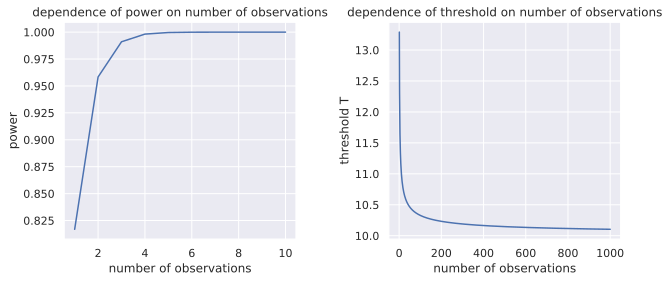

In [74]:
power_list = []
T_list = []

for k in range(1, 1001):
    T = norm.ppf(1 - alpha, T1, sigma1 / k ** 0.5)
    T_list.append(T)
    beta_param = norm.cdf(T, T2, sigma2 / k ** 0.5)
    power_list.append(1 - beta_param)

    
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(np.arange(10) + 1, np.array(power_list)[:10])
ax[0].set_title('dependence of power on number of observations')
ax[0].set_xlabel('number of observations')
ax[0].set_ylabel('power')

ax[1].plot(np.arange(len(power_list)) + 1, T_list)
ax[1].set_title('dependence of threshold on number of observations')
ax[1].set_xlabel('number of observations')
ax[1].set_ylabel('threshold T')
plt.subplots_adjust(wspace=0.4, hspace=0)


**Выводы:** Значение мощности критерий растет с увеличением числа наблюдений и, достигнув значения 1, остается константным (так как это максимально возможное значение мощности критерия). Порог T при этом монотонно"сдвигается" к среднему значению распределения нулевой гипотезы (см второй график): чем больше наблюдений, тем меньше их эмпирическое среднее может отстоять от среднего нулевой гипотезы, чтобы она не была отклонена в пользу альтернативной.

### Задача 3

В 5 серии 13 сезона передачи “Разрушители легенд” проверялась справедливость выражения “know something like the back of one’s hand”. В эксперименте принимало участие 12 испытуемых. Каждому из них были предъявлены 10 фотографий похожих рук разных людей, среди которых они должны были угадать свою.
11 из 12 испытуемых выбрали свою фотографию.
\($H_0$\): испытуемые выбирают фотографии тыльной стороны руки наугад (\($p$=0.1\)).
\($H_1$\): испытуемые выбирают фотографию тыльной стороны своей собственной руки осознанно (\($p>0.1$\)).


Воспользуйтесь точным биномиальным критерием для проверки (H_0) против альтернативы (H_1). Для этого:

	• Постройте нулевое распределение статистики числа успехов в выборке распределения Бернулли с параметром p. Сформируйте выборку сами напрямую из условия задачи.
	• Напишите функцию, которая принимала бы на вход тройку чисел (np,nq,p0), где np – число успехов, nq – число неудач в выборке размера np + nq, p0 – значение параметра p, задающего нулевую гипотезу. Ваша функция должна возвращать значение достигаемого уровня значимости против правосторонней альтернативы.
	• Визуально сравните поведение значения, выдаваемые вашей функцией со стандартным тестом
    scipy.stats.binom_test(·)
	• Отвергается ли гипотеза (H_0) на достигаемом уровне значимости 0.05? p-value?

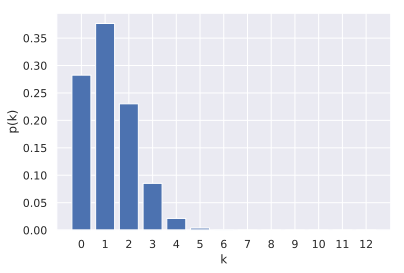

In [75]:
bin_val = []
n = 12
p = 0.1

for k in range(n + 1):
    bin_val.append(binom.pmf(k, n, p))
    
plt.bar(np.arange(n + 1), bin_val)
plt.xticks(np.arange(n + 1))
plt.xlabel('k')
plt.ylabel('p(k)');

In [76]:
def p_val(np, nq, p0):
    return 1 - binom.cdf(np - 1, np + nq, p0)

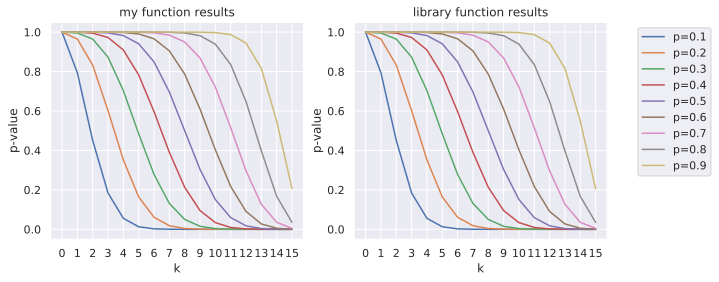

In [77]:
from scipy.stats import binom_test

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

n = 15
for p in [0.1 * x for x in range(1, 10)]:
    my_list = []
    lib_list = []
    for k in range(n + 1):
        assert np.abs(p_val(k, n - k, p) - binom_test(x=(k, n - k), p=p, alternative='greater')) < 1e-7
        my_list.append(p_val(k, n - k, p))
        lib_list.append(binom_test(x=(k, n - k), p=p, alternative='greater'))
    ax[0].plot(my_list, label='p={:.1}'.format(p))
    ax[1].plot(lib_list, label='p={:.1}'.format(p))
ax[0].set_title('my function results')
ax[1].set_title('library function results')
ax[0].set_xlabel('k')
ax[1].set_xlabel('k')
ax[0].set_ylabel('p-value')
ax[1].set_ylabel('p-value')
ax[0].set_xticks(np.arange(n + 1))
ax[1].set_xticks(np.arange(n + 1))
plt.legend(bbox_to_anchor=(1.1, 1.0));

In [78]:
p_val(11, 1, 0.1)

1.0900003122316093e-10

**Выводы:** Было произведено сравнение поведения функции p_val с библиотечной функцией scipy.stats.binom_test, эксперименты не выявили различий в их работе (с точностью до незначительных погрешностей). 

Значение p-value меньше 0.05, следовательно, гипотеза H_0 отвергается в пользу альтернативной.

### Задача 4

24 умственно отсталых ребёнка с СДВГ в течение недели принимали либо метилфенидат, либо плацебо, а в конце недели проходили тест на способность к подавлению импульсивных поведенческих реакций. На втором этапе плацебо и препарат менялись, после недельного курса каждый испытуемые проходили второй тест.
Каков эффект препарата?

In [113]:
adhd = pd.read_csv("ADHD.txt", sep=' ')
adhd.sample(5)

,D0,D60
4,34,38
6,71,77
8,34,45
11,42,57
9,53,42


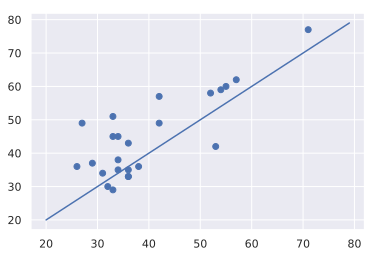

In [132]:
plt.scatter(adhd['D0'], adhd['D60'])
plt.plot(np.arange(20, 80), np.arange(20, 80));

Чтобы использовать $t$-критерий Стьюдента для связанных выборок, необходимо проверить, нет ли существенных отклонений от нормальности попарных разностей. Для этого воспользуйтесь визуальной проверкой нормальности (функция `qqplot` из `statsmodels`), a также библиотечным тестом проверки нормальности: `scipy.stats.shapiro`

In [117]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro

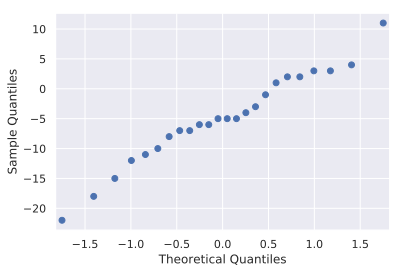

In [121]:
qqplot(adhd['D0'] - adhd['D60']);

In [122]:
shapiro(adhd['D0'] - adhd['D60'])

(0.9798052906990051, 0.8922504186630249)

Точки, полученные с помощью qqplot, расположены не строго по диагонали, поэтому этот способ не дает нам оснований утверждать о нормальности распределения выборки попарных разностей. Однако значение p-value теста Шапиро-Уилка значительно превышает 0.05, следовательно, мы можем с достаточно большой долей уверенности принять гипотезу H_0 о нормальности.

Примените $t$-критерий Стьюдента `scipy.stats.ttest_rel` для связанных выборок.

In [123]:
from scipy.stats import ttest_rel

In [124]:
ttest_rel(adhd['D0'], adhd['D60'])

Ttest_relResult(statistic=-3.2223624451230406, pvalue=0.003771488176381471)

Если бы у нас не было информации о связях между выборками, пришлось бы применять версию критерия Стьюдента для независимых выборок `scipy.stats.ttest_ind`. Сравните результаты применения критерия Стьюдента к этим данным, если считать выборки связанными и не связанными. В какои из этих случаев уровень достигаемой значимости меньше? Как вы думаете почему?

In [125]:
from scipy.stats import ttest_ind

In [126]:
ttest_ind(adhd['D0'], adhd['D60'])

Ttest_indResult(statistic=-1.452163501815909, pvalue=0.1532433046938409)

**Выводы:** В данной задаче гипотезе H_0 соответствует ситуация, когда эффект от препарата отсутствует (способность к подавлению импульсивных поведенческих реакций не изменилась), альтернативная гипотеза двухсторонняя. 

Применение критерия для связанных выборок дает значение p-value меньше 0.05, что соответствует принятию альтернативной гипотезы (есть эффект от препарата). Применение критерия для независимых выборок дает значительно большее значение p-value, что не дает оснований для отвержения гипотезы H_0. 

Это может быть связано с тем, что диапазон различных значений измеряемого показателя достаточно большой (см график в начале), а изменение показателя относительно небольшое и не выводит из первоначального диапазона. То есть если показатель увеличился для одного из пациентов, то же самое значение может быть исходным значением (полученным в первом эксперименте) другого пациента. Критерий для связных выборок учитывает тот факт, что значения в двух выборках принадлежат одной и той же группе пациентов, то есть исходные показатели второй группы пациентов равны значениям первой выборки. Критерий для независимых выборок предполагает, что группы пациентов в первом и втором экспериментах могут быть разными. Он допускает возможность того, что исходные показатели второй группы пациентов были выше, чем у первой, и эффекта от препарата нет. 

### Задача 5

Задана выборка $Y$ результатов распознавания для некоторой задачи классификации.

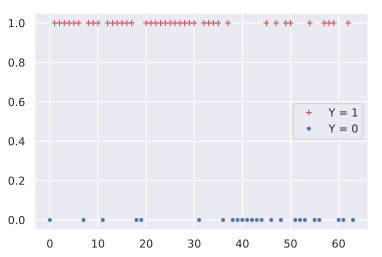

In [133]:
Y = pd.read_excel("t2_data.xlsx").values.ravel()

plt.plot(np.arange(Y.size)[Y == 1], np.count_nonzero(Y == 1) * [1], 'r+', label='Y = 1')
plt.plot(np.arange(Y.size)[Y == 0], np.count_nonzero(Y == 0) * [0], 'b.', label='Y = 0')
plt.legend()
plt.show()

Оцените доверительный интервал для показателя *ACCURACY* с использованием...

Метода Клоппера-Пирсона (с использованием аппроксимации через __бета__ распределение).

    http://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval
    alpha confidence intervals for a binomial distribution of k expected successes on n trials

In [150]:
def bin_clopper_pearson(data, alpha=0.05):
    k = np.sum(data)
    n = data.shape[0]
    low = beta.ppf(alpha / 2, k, n - k + 1)
    up = beta.ppf(1 - alpha / 2, k + 1, n - k)
    
    return low, up

А также с помощью __нормальной__ аппроксимации

In [151]:
def bin_normal_approx(data, alpha=0.05):
    p_hat = np.sum(data) / data.shape[0]
    quant = norm.ppf(1 - alpha / 2)
    coeff = np.sqrt(p_hat * (1 - p_hat) / data.shape[0])
    low = p_hat - quant * coeff
    up = p_hat + quant * coeff
    
    return low, up

Сравните результаты и сделайте выводы.

In [152]:
res = defaultdict(list)
res["alpha"] = alpha_list
res["Clopper-Pearson"] = [np.round(bin_clopper_pearson(Y, alpha), 3) for alpha in alpha_list]
res["Normal"] = [np.round(bin_normal_approx(Y, alpha), 3) for alpha in alpha_list]
res = pd.DataFrame(res)
res

,alpha,Clopper-Pearson,Normal
0,0.100,"[0.515, 0.726]","[0.525, 0.725]"
1,0.075,"[0.506, 0.733]","[0.517, 0.733]"
2,0.050,"[0.495, 0.743]","[0.506, 0.744]"
3,0.025,"[0.478, 0.757]","[0.489, 0.761]"
4,0.010,"[0.457, 0.774]","[0.469, 0.781]"


Также сравните ваши реализованные метод с библиотечными: `statsmodels.stats.proportion.proportion_confint`, в вариантах  `proportion_confint(k, n, alpha, 'beta')` и `proportion_confint(k, n, alpha, 'normal')`

In [149]:
from statsmodels.stats.proportion import proportion_confint

In [153]:
k = np.sum(Y)
n = Y.shape[0]

res_lib = defaultdict(list)
res_lib["alpha"] = alpha_list
res_lib["Clopper-Pearson"] = [np.round(proportion_confint(k, n, alpha, 'beta'), 3) for alpha in alpha_list]
res_lib["Normal"] = [np.round( proportion_confint(k, n, alpha, 'normal'), 3) for alpha in alpha_list]
res_lib = pd.DataFrame(res)
res_lib

,alpha,Clopper-Pearson,Normal
0,0.100,"[0.515, 0.726]","[0.525, 0.725]"
1,0.075,"[0.506, 0.733]","[0.517, 0.733]"
2,0.050,"[0.495, 0.743]","[0.506, 0.744]"
3,0.025,"[0.478, 0.757]","[0.489, 0.761]"
4,0.010,"[0.457, 0.774]","[0.469, 0.781]"


**Выводы:** Поведение реализованных методов совпадает с библиотечными (с измеренной точностью). 

Нормальная аппроксимация основана на законе больших чисел, а значит неприменима для выборок небольшого размера. В нашем случае n=64, а значит использование этого метода может давать некорректные результаты. Критерий Клоппера-Пирсона учитывает, что выборка распределена биномиально, и подходит даже для выборок небольшого размера, но дает слишком "консервативные" результаты. Эксперименты показывают, что для большинства значений alpha доверительный интервал нормальной аппроксимации вложен в доверительный интервал, полученный с помощью критерия Клоппера-Пирсона, что подтверждает "консервативность" последнего.